In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
from static_grader import grader

# Image Classification with TensorFlow

Image classification is a common task for deep learning and neural networks.  The raw features coming in are the pixel values.  These are simple enough to deal with, but it is difficult to connect pixel values to determining whether an image is of a cat.  Older methods used a lot of clever filters, but the current best-of-breed algorithms simply throw a lot of linear algebra at the problem.

In this miniproject, you build a series of models to classify a series of images into one of ten classes. For expediency, these images are pretty small ($32\times32\times3$).  This can make classification a bit tricky&mdash;human performance is only about 94%.  Each of your models will be scored by comparing its accuracy to the accuracy of a reference model that we developed.  A score of 1 indicates that your model performs as well as the reference model; not that your accuracy is 100%!

You will be given both a training set and a validation set.  Ground truth values are provided for the training set.  You should train your models on this set, and then make predictions for each of the validation images.  These predictions will be submitted to the grader.

## A note on scoring

It **is** possible to score above 1 on these questions. This indicates that you've beaten our reference model&mdash;we compare our model's score on a test set to your score on a test set. See how high you can go!

## Downloading the data

We will be using the `CIFAR-10` data set.  It consists of 60,000 images, each $32\times32$ color pixels, each belonging to one of ten classes.  The following cell will download the data, in NumPy's `.npy` format.

In [1]:
!aws s3 sync s3://dataincubator-course/cifar10/ .

We can load in the data like so:

In [2]:
import numpy as np

train_images = np.load(open('train_images.npy', 'rb'))
train_labels = np.load(open('train_labels.npy', 'rb'))
validation_images = np.load(open('validation_images.npy', 'rb'))

The images are stored as four-dimensional arrays.  The first index indicates the image number, the second and third the $x$ and $y$ positions, and the fourth index the color channel.  Each pixel color is a floating point number between 0 and 1.  This convention allows us to view the images with matplotlib:

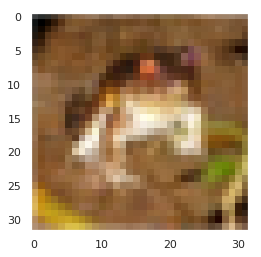

In [5]:
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(train_images[0])

The classes have already been numbered 0-9 for us; those numbers are stored in the vector `train_labels`.

In [6]:
train_labels[0]

6

The human-readable names associated with this classes are

In [4]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [40]:
train_labels

array([6, 9, 9, ..., 9, 1, 1])

So we can see that the image above is a frog.  (Now you see it!)

## TensorFlow resets

The cell below includes the same reset code we use in the rest of module.  You're welcome to use it if it's helpful, but it's not necessary.

In [5]:
import tensorflow as tf

sess = None

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

def reset_vars():
    sess.run(tf.global_variables_initializer())
    
reset_tf()

# Questions

## Perceptual Delta

Since we already have a number of labeled images, a simple approach would be to measure the difference between two images, and choose the label corresponding to nearby images.  To do this, we need to develop a metric to determine the distance between two images.  We'll make the simplifying (and completely wrong) assumption that this is just the average difference between the colors of the corresponding pixels in the two images.

While we could just take RMS difference of the red, green, and blue pixels, let's be slightly more sophisticated and look at human vision for a metric.  After all, we're pretty good at image classifications, so there might be some useful optimization here.

It turns out that modeling human perception is [extraordinarily complicated](https://en.wikipedia.org/wiki/Color_difference#CIEDE2000).  We're going to use a [simplified model](https://www.compuphase.com/cmetric.htm):

$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

This accounts for the fact that our eyes are most sensitive to green and least sensitive to red, and that perception is not constant with hue.

Build a graph that takes in a series of images, as well as a base image, and returns a result containing the $\Delta C$ value (for each pixel) between the base image and each image in the series.  

(Note that the intention here in our solution is that `images` will be a TensorFlow placeholder that can, for example, contain the entire set of training images, while `base` is another TensorFlow placeholder that contains a single image.  Since the inputs are TensorFlow placeholders, the output from this function will be a tensor, hence our use of the word "graph" for the output.)  

In [5]:
import math
def delta_func(images, base):
    Ni,Nx,Ny,Nc=images.shape
    dR=tf.subtract(images[0:Ni,:,:,0], base[:,:,0])
    dG=tf.subtract(images[0:Ni,:,:,1], base[:,:,1])
    dB=tf.subtract(images[0:Ni,:,:,2], base[:,:,2])
    bR=tf.add(images[0:Ni,:,:,0], base[:,:,0])/2
    dC=(2*dR**2+4*dG**2+3*dB**2+bR*(dR**2-dB**2))**0.5
    dC=tf.reduce_mean(dC, axis=(1,2),)
#    dC=dC.mean(axis=(1,2))
    return dC
#delta_func(train_images[1:,:,:,:], train_images[0,:,:,:])

As stated, for two images, $I_1$ and $I_2$, we define the distance between $I_1$ and $I_2$ as the average $\Delta C$ value over the whole image, that is:

$$d(I_1, I_2) = \frac{1}{N}\sum_{p_j} \Delta C(p_j)$$
where the sum is over all pixels $p_j$, $\Delta C(p_2)$ is the $\Delta C$ value for the pixel $p_j$, and $N$ is the total number of pixels in each image ($N= 32\times 32$ in our case).  

So use `delta_func` to define a graph that takes a series of images and a base image and returns the distance (the average $\Delta C$ value) between the base image and each image in the series.  First we need to define the TensorFlow placeholders `images` and `base` that will contain, respectively, a set of images and a single image.  

In [43]:
Ni,Nx,Ny,Nc=train_images.shape
images = tf.placeholder(tf.float32, shape=(Ni,Nx,Ny,Nc))
base = tf.placeholder(tf.float32, shape=(Nx,Ny,Nc))
with tf.Session() as sess:
    deltas = sess.run(delta_func(images,base), feed_dict={images: train_images,base:validation_images[0,:,:,:]})

In [50]:
indices=np.argsort(deltas)[:100]

Now, compute the distance between the first validation image and all of the training images.

**Checkpoint:** The mean value of the distances is 1.159, and the standard deviation of the distances is 0.182.

From these, find the 100 closest images from the training set to this image.  (Note that `numpy.argsort` might help here.)  Submit a list of the indices of these images to the grader.

In [51]:
#indices = [43234]*100

grader.score('tf__perceptual_delta', indices)

Your score:  1.0


**Extension:** What does this suggest about the proper class for this image?

> **Aside:** Essentially, we've started to implement a $k$-nearest neighbors algorithm, using this perceptual distance as our metric.  If we ran the difference between all of the validation images and each of the training images, we could make a prediction from the nearest images for each.  Give it a try, if you're interested, but this miniproject is going to go in another direction.

## Smallest delta model

Instead of comparing each validation image to each training image, let's generate a "typical" image for each class.  This typical image will be the one that minimizes the total (or average) perceptual delta from all training images in this class.  We could do that through some clever averaging, but let's treat it as a minimization problem so that we can do gradient descent.  

This problem will have two steps, the first step is to train a typical image for each class in the training set, the second will be to make predictions on the validation set.  These predictions will be based on the closest "typical" image trained in the first step.

Make the typical image a TensorFlow variable, starting with random pixel values.  It's this TensorFlow variable that we will train by performing gradient descent.

In [7]:
Ni,Nx,Ny,Nc=validation_images.shape
typical=tf.Variable(tf.random_normal([Nx,Ny,Nc], stddev=.5, mean=.5)/2, dtype=np.float32)
#typical = tf.Variable((((.5**2)*(np.random.randn(Nx,Ny,Nc))+1)/2), dtype=np.float32).initialized_value()

In [64]:
def reset_vars():
    sess.run(tf.global_variables_initializer())

In [14]:
#np.argsort(deltas)[0]

Define an error function that measures the difference between that typical image and a set of images. You should be able to use the same `delta_func` you defined in the first problem.  You can also reuse the `images` placeholder from the first problem, but instead of the placeholder `base` you need to use the variable `typical` you just defined, since this is what we are trying to train via gradient descent.  

In [15]:
#Ni,Nx,Ny,Nc=train_images.shape
#images = tf.placeholder(tf.float32, shape=(Ni,Nx,Ny,Nc))
#with tf.Session() as sess:
#    reset_vars()
#    error = sess.run(delta_func(images,typical), feed_dict={images: train_images,typical:typical.eval()})

In [29]:
Ni,Nx,Ny,Nc=train_images.shape
img = tf.placeholder(tf.float32, shape=(None,Nx,Ny,Nc))
error = tf.reduce_mean(delta_func(img,typical))

Now, we will use gradient descent to find a typical image in order to minimize the error.  We want to do this for each of the ten classes of images, but let's first concentrate on how we do this for a single class (we can roll the code into a `for` loop later).  

First let's get the images that belong to a single class, say class 6 (corresponding to the first training image).

In [30]:
label = 6
Ni,Nx,Ny,Nc=train_images.shape
index=[]
for i in range(Ni):
    if train_labels[i]==label:
        index.append(i)
ims =train_images[index,:,:,:].astype('float32')

Now define the gradient descent optimizer, and the method that will minimize the error function defined above.  Remember that you need to specify a learning rate for the optimizer.  You might need to later experiment with the learning rate to find the right value so the training will converge to the minimum (and converge quickly).  (__Note:__  "Normal" learning rates are typically in the range 0.1 to 1, perhaps even smaller in some situations.  The learning rate we used in our solution was an order of magnitude larger than that.)  

In [60]:
import tensorflow as tf
eta = 1
optimizer=tf.train.AdamOptimizer(eta)
#optimizer = tf.train.GradientDescentOptimizer(eta)
train = optimizer.minimize(error)

__Comment/Reminder:__  What is the gradient descent optimizer doing during the training procedure?  Assuming everything previously has been defined correctly, the only _variable_ in the error function is `typical`, so this is the only thing that the optimizer can alter when attempting to minimize the error function.  It's important to understand this detail, as our goal is to train (find) the typical image during the optimization procedure.  

Before we forget, since it's a TensorFlow variable, we need to initialize `typical` before we start the training.  

In [61]:
# What do I need to do here?
with tf.Session() as sess:
    reset_vars()
    for _ in range(20):
        sess.run(train, feed_dict={img: ims})
    typical6=typical.eval()

Keeping in mind that our training set (for a single label) consists of 5,000 images, let's perform the training in batches.  To ensure good training, let's pick our batches randomly from the set of training images.  

Strictly speaking, we are performing a batched version of __stochastic gradient descent__.  

In [ ]:
BATCH_SIZE = ...
EPOCHS = ...
for ep in ...
...
<Do training here...>

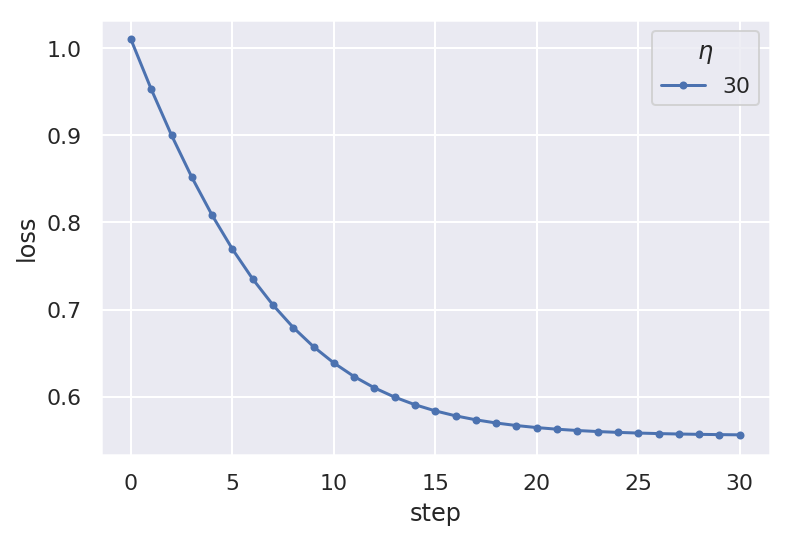

In [101]:
#best e=30, rnge(30)
etas = [30]
errors = []
BATCH_SIZE = 100

for e in etas:
    with tf.Session() as sess:
        reset_vars()
        #optimizer=tf.train.AdamOptimizer(e)
        optimizer = tf.train.GradientDescentOptimizer(e)  # learning rate
        train = optimizer.minimize(error)
        errors.append([sess.run(error, feed_dict={img: ims})])
        for i in range(30):
            sess.run(train, feed_dict={img: ims})
            errors[-1].append(sess.run(error, feed_dict={img: ims}))
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import expectexception
plt.plot(np.array(errors).T, '.-')
plt.legend(etas, title=r'$\eta$')
plt.xlabel('step')
plt.ylabel('loss');

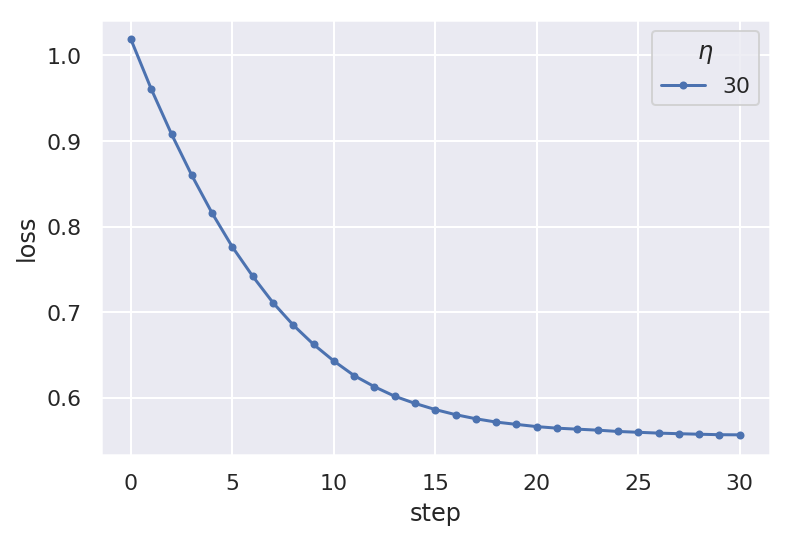

In [100]:
etas = [30]
errors = []
BATCH_SIZE = 100

for e in etas:
    with tf.Session() as sess:

        reset_vars()
        optimizer = tf.train.GradientDescentOptimizer(e)
        train = optimizer.minimize(error)
        errors.append([sess.run(error, feed_dict={img: ims})])
        for i in range(30):
            j = np.random.choice(len(ims[:, 1,1,1]), BATCH_SIZE, replace=False)
            sess.run(train, feed_dict={img: ims[j, :,:,:]})
            errors[-1].append(sess.run(error, feed_dict={img: ims}))

plt.plot(np.array(errors).T, '.-')
plt.legend(etas, title=r'$\eta$')
plt.xlabel('step')
plt.ylabel('loss');

__Checkpoint:__  Here's the typical image we generated for label 6 when we did the training.  

download: s3://dataincubator-course/miniprojects/tf/typical_6.npy to ./typical_6.npy


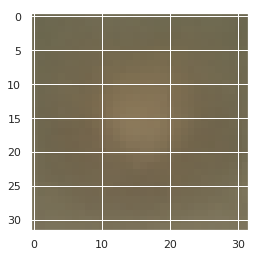

In [39]:
!aws s3 sync s3://dataincubator-course/miniprojects/tf/ .

matplotlib.pyplot.imshow(np.load(open('typical_6.npy','rb')))

You can compare this to the first four frog (class label 6) training images. A perfect fit, right?  

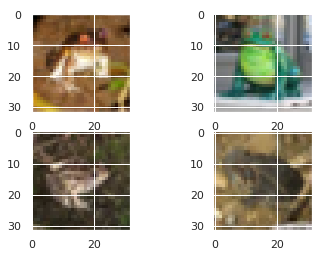

In [40]:
frogs = np.where(train_labels == 6)[0]   #  Get the indices for the frogs

fig, ax = matplotlib.pyplot.subplots(2, 2)
for i in range(4):
    np.ravel(ax)[i].imshow(train_images[ frogs[i] ])

matplotlib.pyplot.show()

Having now done this training for one class, it should be easy to roll this code into a `for` loop to generate a typical image for each of the 10 classes.  Don't forget to save your typical image for each class, as they are needed for the prediction step.  

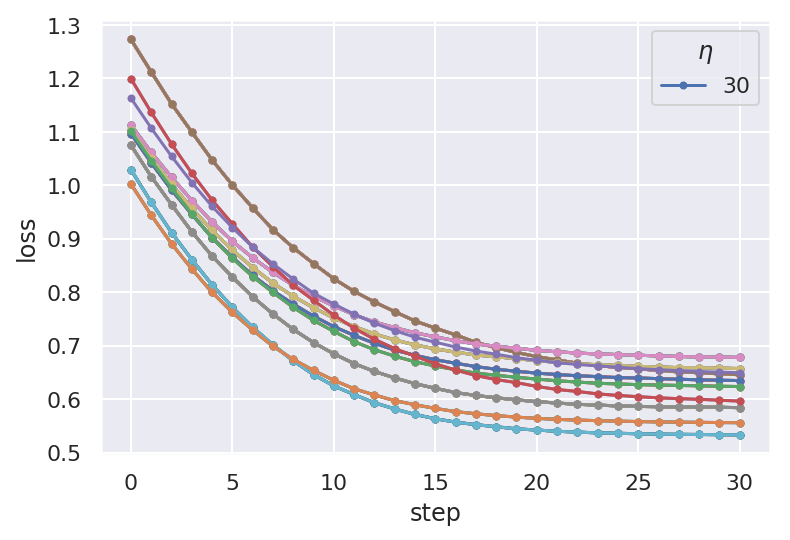

In [104]:
Ni,Nx,Ny,Nc=train_images.shape
typicals=[]
etas = [30]
errors = []
BATCH_SIZE = 100
for i in range(10):
    label = i
    index=[]
    for i in range(Ni):
        if train_labels[i]==label:
            index.append(i)
    ims =train_images[index,:,:,:].astype('float32')

    for e in etas:
        with tf.Session() as sess:

            reset_vars()
            optimizer = tf.train.GradientDescentOptimizer(e)
            train = optimizer.minimize(error)
            errors.append([sess.run(error, feed_dict={img: ims})])
            for i in range(30):
                j = np.random.choice(len(ims[:, 1,1,1]), BATCH_SIZE, replace=False)
                sess.run(train, feed_dict={img: ims[j, :,:,:]})
                errors[-1].append(sess.run(error, feed_dict={img: ims}))
            typicals.append(typical.eval())
    plt.plot(np.array(errors).T, '.-')
    plt.legend(etas, title=r'$\eta$')
    plt.xlabel('step')
    plt.ylabel('loss');

Finally, we're ready to make a prediction for each validation image based on which typical image is nearest under our distance metric.  You need to generate a list of 10,000 integers, representing the predicted class of each validation image.   

__Hint:__ Use the graph you defined from question 1 to find the distance between each validation image and a _single_ typical image, and repeat for each typical image to create a `numpy` array of distances having shape (10000,10).  You should then find the `np.argmin()` function helpful in finding the predicted label for each validation image.  

In [153]:
Ni,Nx,Ny,Nc=validation_images.shape
images = tf.placeholder(tf.float32, shape=(Ni,Nx,Ny,Nc))
base = tf.placeholder(tf.float32, shape=(Nx,Ny,Nc))
deltas_all=[]
for i in range(len(typicals)):
    with tf.Session() as sess:
        deltas = sess.run(delta_func(images,base), feed_dict={images: validation_images,base:typicals[i]})
        deltas_all.append(deltas)
valid_cat=[]
for i in range(len(validation_images)):
    min_delta=10
    for j in range(10):
        if deltas_all[j][i]< min_delta:
            min_delta=deltas_all[j][i]
            min_delta_n=j
    valid_cat.append(min_delta_n)


In [156]:
predicted_classes = valid_cat
#predicted_classes = return [0]*len(validation_images)
grader.score('tf__smallest_delta', predicted_classes)

Your score:  0.980816184164632


We suggest storing your typical images in a file using the `numpy` "save" function.  That function allows you to save a `numpy` array to a binary file.  That way if you need to restart this notebook, you can reload your typical images you have already trained (not having to re-run the code above to create these typical images again).  (We used `numpy.load` near the start of this notebook to load the training and validation images that were stored in this binary format.)

## Softmax model

Looking only at the smallest distance is throwing some information away.  We would expect some classes to have more variation that others.  Also, we would expect correlation between the classes&mdash;a small distance to *cat* is probably more likely for *dog* than for *airplane*.

Instead of a trying to work out these effects heuristically, let the computer do it.  Build a softmax model that takes as input features the distances from all ten typical images and makes a class prediction from those.  Again, use this to predict the class for each of the validation images.

**Hint:**
- The labels are given as integers, but softmax expects one-hot encoding of the labels.  The `tf.one_hot` function can do the conversion.

In [257]:
#predicted_classes = return [0]*len(validation_images)
predicted_classes = valid_cat
grader.score('tf__softmax', predicted_classes)

NameError: name 'valid_cat' is not defined

**Extension:** Does this perform any better than the previous solution?  What metric is the right one to use to make this judgment?

## Fully-connected model

The previous model still makes the assumption that this distance metric is the right measure to use.  In this problem, we'll give this up.  Build a multi-layer fully-connected neural network that takes the pixel values as input and yields a class prediction as output.

**Hints:**
- We found that adding more layers didn't help too much.
- Watch out for over-fitting.  Drop-out can help with this.
- The reference solution achieves an accuracy of about 44% on a training set and 41% on a test set.

In [3]:
from __future__ import print_function
import tensorflow as tf

In [4]:
from tensorflow.keras.utils import to_categorical as one_hot
# Parameters
learning_rate = 0.1
num_steps = 500
batch_size = 200
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 32*32*3 # MNIST data input (img shape: 32*32)
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

X_train=train_images.reshape(len(train_images), -1)
X_test=validation_images.reshape(len(validation_images), -1)

y_train = one_hot(train_labels)
#y_test  = one_hot(y_test)

In [81]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


In [82]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [83]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [84]:
# Construct model
logits = neural_net(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [85]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
#        batch_x, batch_y = mnist.train.next_batch(batch_size)
        batch_x, batch_y=next_batch(batch_size,X_train, y_train)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for MNIST test images
#    print("Testing Accuracy:", \
#        sess.run(accuracy, feed_dict={X: mnist.test.images,
#                                      Y: mnist.test.labels}))

Step 1, Minibatch Loss= 31089.8027, Training Accuracy= 0.093
Step 100, Minibatch Loss= 2047.6156, Training Accuracy= 0.199
Step 200, Minibatch Loss= 258.2664, Training Accuracy= 0.224
Step 300, Minibatch Loss= 39.7253, Training Accuracy= 0.278
Step 400, Minibatch Loss= 20.1905, Training Accuracy= 0.256
Step 500, Minibatch Loss= 14.1963, Training Accuracy= 0.266
Step 600, Minibatch Loss= 11.5963, Training Accuracy= 0.250
Step 700, Minibatch Loss= 8.1993, Training Accuracy= 0.263
Step 800, Minibatch Loss= 7.1593, Training Accuracy= 0.237
Step 900, Minibatch Loss= 5.2635, Training Accuracy= 0.235
Step 1000, Minibatch Loss= 4.9307, Training Accuracy= 0.266
Step 1100, Minibatch Loss= 4.7950, Training Accuracy= 0.285
Step 1200, Minibatch Loss= 4.9651, Training Accuracy= 0.274
Step 1300, Minibatch Loss= 4.1291, Training Accuracy= 0.275
Step 1400, Minibatch Loss= 4.2758, Training Accuracy= 0.285
Step 1500, Minibatch Loss= 3.9840, Training Accuracy= 0.282
Step 1600, Minibatch Loss= 3.7033, Trai

In [14]:
#c1,c2=tf.train.batch([X_train, y_train], batch_size=5)

In [35]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


In [6]:
#notebook method
# Model parameters
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import time
from datetime import datetime, timedelta
#import pylib
#import pylib.conv_widget as cw
#from pylib.tensorboardcmd import tensorboard_cmd
from tensorflow.keras.utils import to_categorical as one_hot
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 1
filt_size = [5, 5] # 5x5 pixel filters

batch_size = 50
n_epochs = 5
model = keras.models.Sequential()

model.add(keras.layers.Reshape([img_size, img_size, 3]))
model.add(keras.layers.Conv2D(16, filt_size, padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.1),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size)

Epoch 1/5
 6350/50000 [==>...........................] - ETA: 31s - loss: 2.2441 - acc: 0.1564

KeyboardInterrupt: 

In [104]:
def predict(idx):
    image = np.array([X_test[idx]])
    return np.argmax(model.predict(image)) 

pred_q4=[]
for i in range(len(validation_images)):
    pred_q4.append(predict(i))


In [256]:
#predicted_classes = return [0]*len(validation_images)
predicted_classes = pred_q4
predicted_classes = pred_q5
grader.score('tf__fully_connected', predicted_classes)

Your score:  1.5531153019813797


## Convolutional model

Convolutional neural networks have had a lot of success in image classification.  Build a neural network with convolutional layers to improve the performance.

**Hints:**
- The reference solution uses two convolutional layers and two fully-connected layers.
- We found success with the `AdamOptimizer`.
- The reference solution achieves an accuracy of 80% on a training set and 70% on a test set.

In [7]:
#q5
#notebook method
# Model parameters
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import time
from datetime import datetime, timedelta
#import pylib
#import pylib.conv_widget as cw
#from pylib.tensorboardcmd import tensorboard_cmd
from tensorflow.keras.utils import to_categorical as one_hot
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 1
filt_size = [5, 5] # 5x5 pixel filters

batch_size = 100
n_epochs = 15
model = keras.models.Sequential()

model.add(keras.layers.Reshape([img_size, img_size, 3]))
model.add(keras.layers.Conv2D(16, filt_size, padding='same',
                              activation='relu'))
#                            activation='softmax'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='same'))
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(1024, activation='sigmoid'))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(n_classes, activation='softmax'))
#model.add(keras.layers.Dense(n_classes, activation='sigmoid'))
#model.add(keras.layers.Dense(n_classes, activation='relu'))
#model.compile(loss='mean_squared_error',
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=.1),
#optimizer=keras.optimizers.Adam(lr=0.01), #works with relu
              metrics=['accuracy'],
              target_tensors=[y_train])

history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size)

Epoch 1/15
50000/50000 [==============================] - 31s 629us/step - loss: 1.8860 - acc: 0.3232
Epoch 2/15
50000/50000 [==============================] - 30s 601us/step - loss: 1.4823 - acc: 0.4703
Epoch 3/15
50000/50000 [==============================] - 29s 572us/step - loss: 1.3016 - acc: 0.5399
Epoch 4/15
50000/50000 [==============================] - 26s 529us/step - loss: 1.1547 - acc: 0.5903
Epoch 5/15
50000/50000 [==============================] - 25s 505us/step - loss: 1.0218 - acc: 0.6362
Epoch 6/15
50000/50000 [==============================] - 26s 514us/step - loss: 0.8828 - acc: 0.6912
Epoch 7/15
50000/50000 [==============================] - 25s 499us/step - loss: 0.7477 - acc: 0.7376
Epoch 8/15
50000/50000 [==============================] - 26s 528us/step - loss: 0.6114 - acc: 0.7862
Epoch 9/15
50000/50000 [==============================] - 25s 502us/step - loss: 0.4876 - acc: 0.8284
Epoch 10/15
50000/50000 [==============================] - 25s 497us/step - loss: 

In [8]:
def predict(idx):
    image = np.array([X_test[idx]])
    return np.argmax(model.predict(image)) 

pred_q5=[]
for i in range(len(validation_images)):
    pred_q5.append(predict(i))


In [9]:
#predicted_classes = return [0]*len(validation_images)
predicted_classes = pred_q5
grader.score('tf__convolutional', predicted_classes)

Your score:  0.8806136680613668


## Transfer learning

In [ ]:
#next method
# minimum InceptionV3 image size is 139x139
# Caltech101 images have all different dimensions
inception = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(139, 139, 3))
for layer in inception.layers:
    layer.trainable = False
batch_size = 128
n_batches = len(X_train) // batch_size
x_train, y_train = dataset.repeat().batch(batch_size).make_one_shot_iterator().get_next()
N_CLASSES = len(set(data.categories))

input_layer = keras.layers.Input(shape=(139, 139, 3),
                                   tensor=x_train)
x = inception(input_layer)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation='sigmoid')(x)
x = keras.layers.Dropout(.5)(x)
y = keras.layers.Dense(N_CLASSES, activation='softmax')(x)

model = keras.models.Model(inputs=input_layer, outputs=y)
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'],
              target_tensors=[y_train])

In transfer learning, we use a network trained on one data set to provide a starting point for the modeling of other data.  As we are trying to model color images, we should look for another network trained on color images.  Luckily, we have already discussed such a network: the `GoogLeNet` network used in the Deep Dream notebook.

The following cell will download the saved network, if necessary, and load it into the current graph.

In [5]:
import os
from urllib.request import urlopen
import zipfile

data_url = "http://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip"
data_dir = os.path.expanduser("~/inception/5h/")
file_path = os.path.join(data_dir, 'inception5h.zip')

if not os.path.exists(file_path):
    # Check if the download directory exists, otherwise create it.
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    # Download
    with open(file_path, "wb") as local_file:
        local_file.write(urlopen(data_url).read())
    # Extract
    zipfile.ZipFile(file_path, mode="r").extractall(data_dir)

path = os.path.join(data_dir, "tensorflow_inception_graph.pb")
with tf.gfile.FastGFile(path, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

In [6]:
from tensorflow.keras.utils import to_categorical as one_hot
X_train=train_images.reshape(len(train_images), -1)
X_test=validation_images.reshape(len(validation_images), -1)

y_train = one_hot(train_labels)

In a transfer learning setup, we will use the first part of the trained network to process the original images, and then train a network to make predictions from the output of the trained network.  There are several ways to accomplish this.

One approach is to connect the new layers to the output of the existing layers.  Data will flow through the pre-trained layers as well as those added.  In the training step, only the new layers should be marked as trainable.

However, this can be a bit wasteful when multiple epochs of training will be undertaken.  With a smaller data set, such as this, it can be more efficient to pre-calculate the *latent vectors* that are the output of the pre-trained network.  These can be stored and used as input for training a smaller, separate network to make the predictions.  We recommend this approach for this miniproject.

Images are to be fed to the `GoogLeNet` network's `input` tensor.  As a reminder, you can get that with the `get_tensor_by_name()` function:

In [7]:
googlenet_input = sess.graph.get_tensor_by_name("input:0")

In [8]:
googlenet_input.shape

TensorShape(None)

If you check the shape of this tensor, you'll see that it's `TensorShape(None)`.  You can feed any tensor into it, and it will compute something.  To get a reasonable output, however, you should feed in the same format that it was trained with, a four-dimensional tensor of shape `[?, 224, 224, 3]`.

This implies that we need to upscale our images from $32\times32$ to $224\times224$.  There are a number of ways to do this; the reference solution uses `scipy.ndimage.zoom()` with the `order=1` parameter.  (Higher orders produce better results, but will take significantly longer!)  The `GoogLeNet` network was trained with pixel values from 0 to 255, so you'll want to scale up the image values appropriately.

You will also need to pick a layer from the `GoogLeNet` model to use as the input to your layers.  Since `GoogLeNet` was trained on images much like our data set, we can use a layer near the end.  You may want to take a look at the `mixed5b` layer (shape `[?, 7, 7, 1024]`) or the `avgpool0` layer (shape `[?, 1, 1, 1024]`).

It may make sense to do the rescaling and latent vector calculation at the same time, to avoid storing the (somewhat large) rescaled images unnecessarily.  You also probably want to save those latent vectors to disk, to avoid the need to repeat this calculation later.

**Hints:**
- Be sure to batch this calculation; sending all 50,000 images through the `GoogLeNet` at once will cause memory errors.
- The latent vector calculation took us about 2 hours on a single machine.  You might consider distributing the calculation.
- The reference solution used latent vectors from the `avgpool0` layer.  The latent vectors for the first 10 images have an average of 778 non-zero values and an overall average value of 0.578.

In [17]:
from scipy import ndimage, misc
result = ndimage.zoom(X_train[:1].reshape(1,32,32,3),(1,7,7,1), order=1)*256
result.shape

(1, 224, 224, 3)

In [18]:
graph_output = sess.graph.get_tensor_by_name("output2:0")
res = sess.run(graph_output, {googlenet_input: result})

In [19]:
labels = [s.strip() for s in 
             open(os.path.join(data_dir, 'imagenet_comp_graph_label_strings.txt')).readlines()]
labels[0:10]
for i in res.argsort()[0][-1:-6:-1]:
    print(labels[i], res[0,i])

patas 0.40785483
langur 0.12409485
macaque 0.07645378
squirrel monkey 0.06901842
proboscis monkey 0.042796068


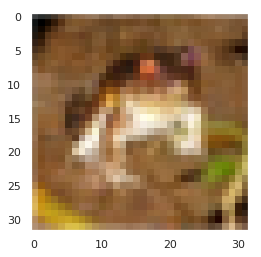

In [20]:
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(X_train[:1].reshape(1,32,32,3)[0])

With the latent vectors calculated, we can use them as input to train a small neural network to make the final predictions.

**Hints:**
- The reference solution has three layers.
- The reference solution achieves a training accuracy of 87% and a test accuracy of 85%.

In [9]:
#predicted_classes = return [0]*len(validation_images)
predicted_classes = pred_q5
grader.score('tf__transfer_learning', predicted_classes)

Your score:  0.7498534755597235


*Copyright &copy; 2019 The Data Incubator.  All rights reserved.*